# Saad Amir
# i200650
# Q1


Epoch 1/30
VAE Loss: 0.2432, GAN D Loss: 0.1911, GAN G Loss: 1.1131

Epoch 2/30
VAE Loss: 0.1773, GAN D Loss: 0.0983, GAN G Loss: 1.1067

Epoch 3/30
VAE Loss: 0.1657, GAN D Loss: 0.0379, GAN G Loss: 0.9325

Epoch 4/30
VAE Loss: 0.1627, GAN D Loss: 0.0435, GAN G Loss: 0.9903

Epoch 5/30
VAE Loss: 0.1610, GAN D Loss: 0.0162, GAN G Loss: 0.9748

Epoch 6/30
VAE Loss: 0.1595, GAN D Loss: 0.0205, GAN G Loss: 0.9045

Epoch 7/30
VAE Loss: 0.1582, GAN D Loss: 0.0108, GAN G Loss: 0.9166

Epoch 8/30
VAE Loss: 0.1568, GAN D Loss: 0.0101, GAN G Loss: 0.9900

Epoch 9/30
VAE Loss: 0.1560, GAN D Loss: 0.0053, GAN G Loss: 0.9970

Epoch 10/30
VAE Loss: 0.1556, GAN D Loss: 0.0055, GAN G Loss: 1.0099

Epoch 11/30
VAE Loss: 0.1549, GAN D Loss: 0.0042, GAN G Loss: 0.9922

Epoch 12/30
VAE Loss: 0.1548, GAN D Loss: 0.0055, GAN G Loss: 0.9979

Epoch 13/30
VAE Loss: 0.1545, GAN D Loss: 0.0045, GAN G Loss: 0.9929

Epoch 14/30
VAE Loss: 0.1548, GAN D Loss: 0.0042, GAN G Loss: 0.9933

Epoch 15/30
VAE Loss: 0.1549

/tmp/ipykernel_31/3874308581.py:283: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 10))


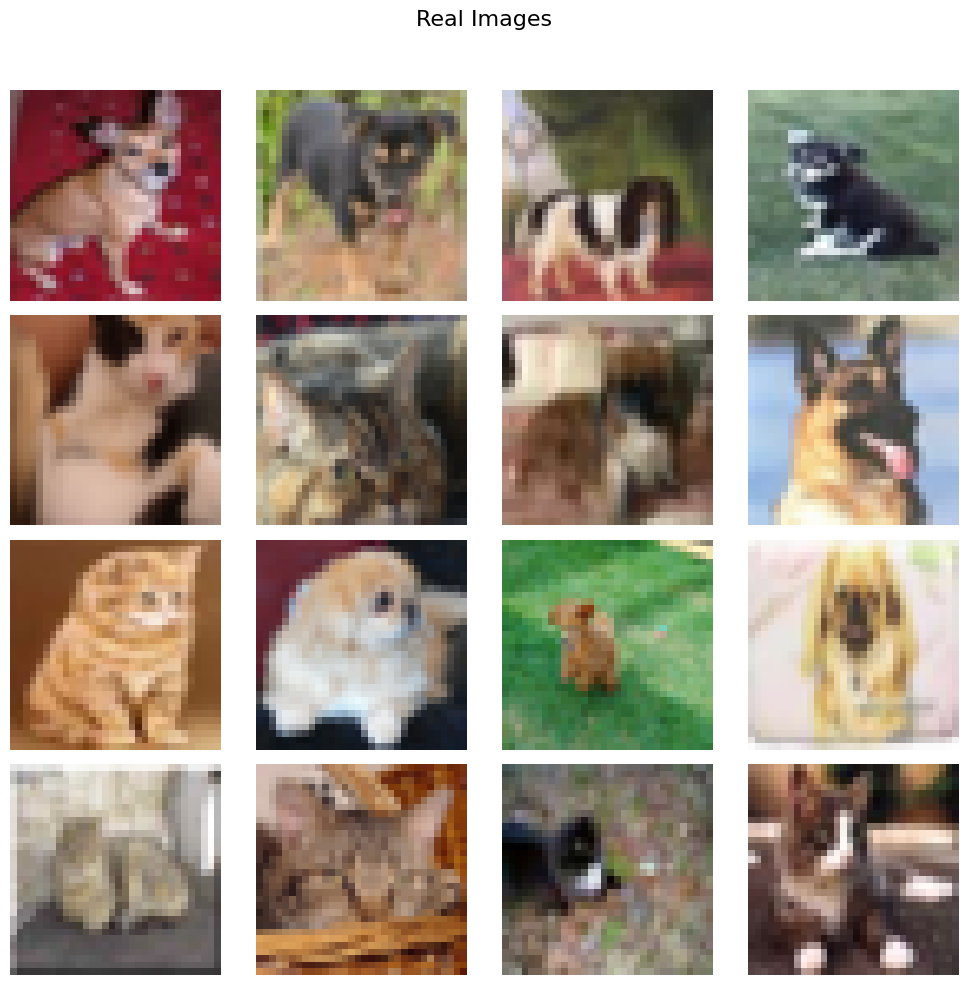

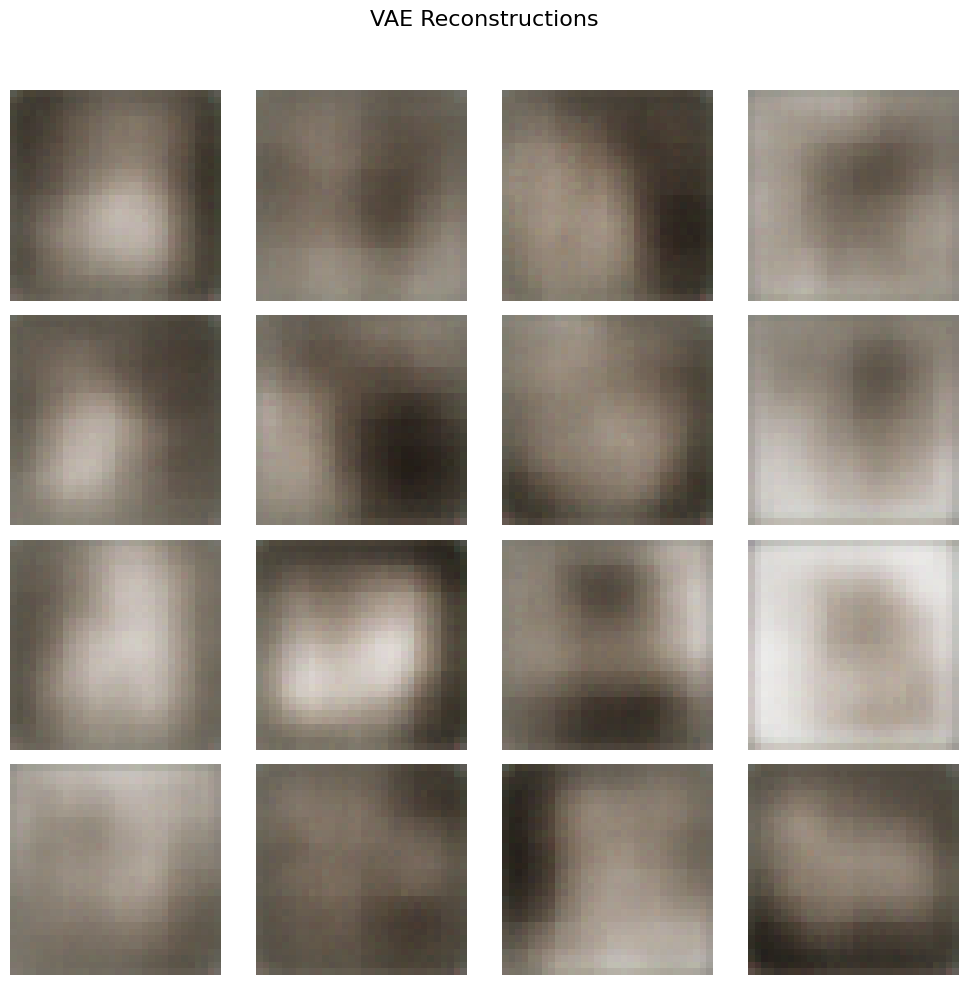

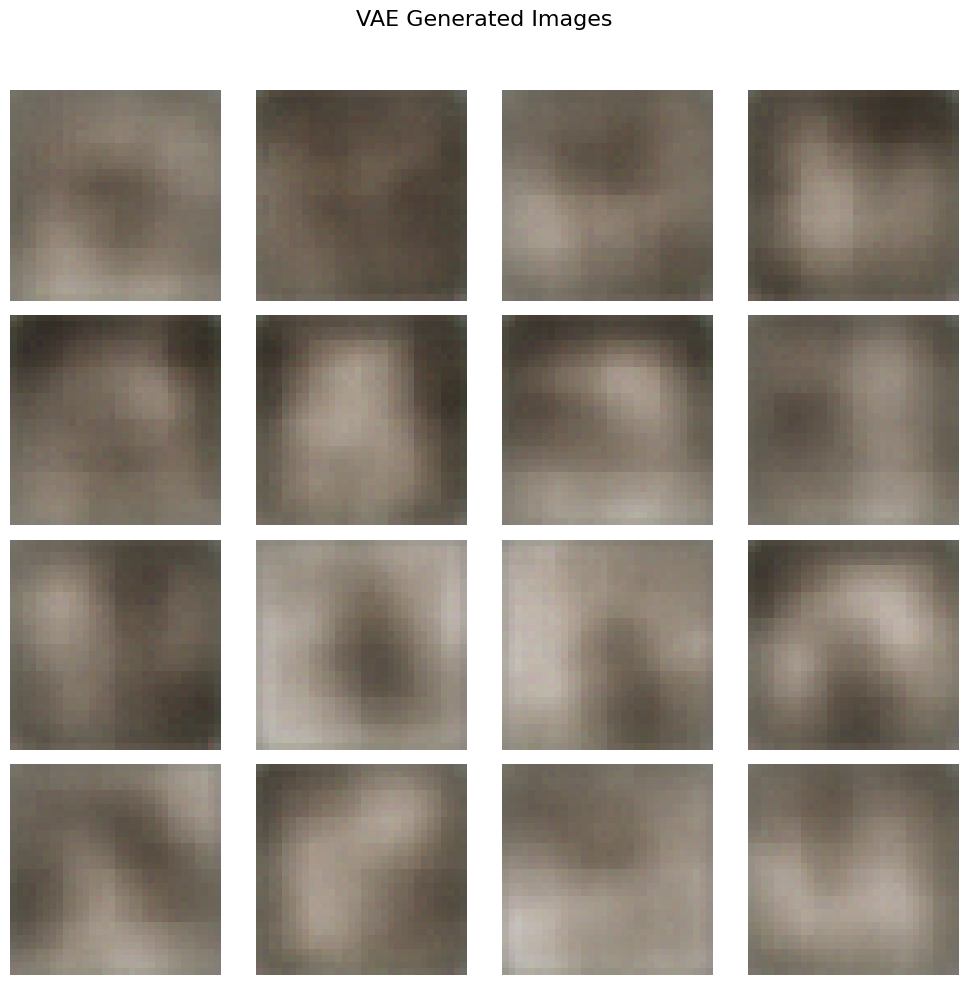

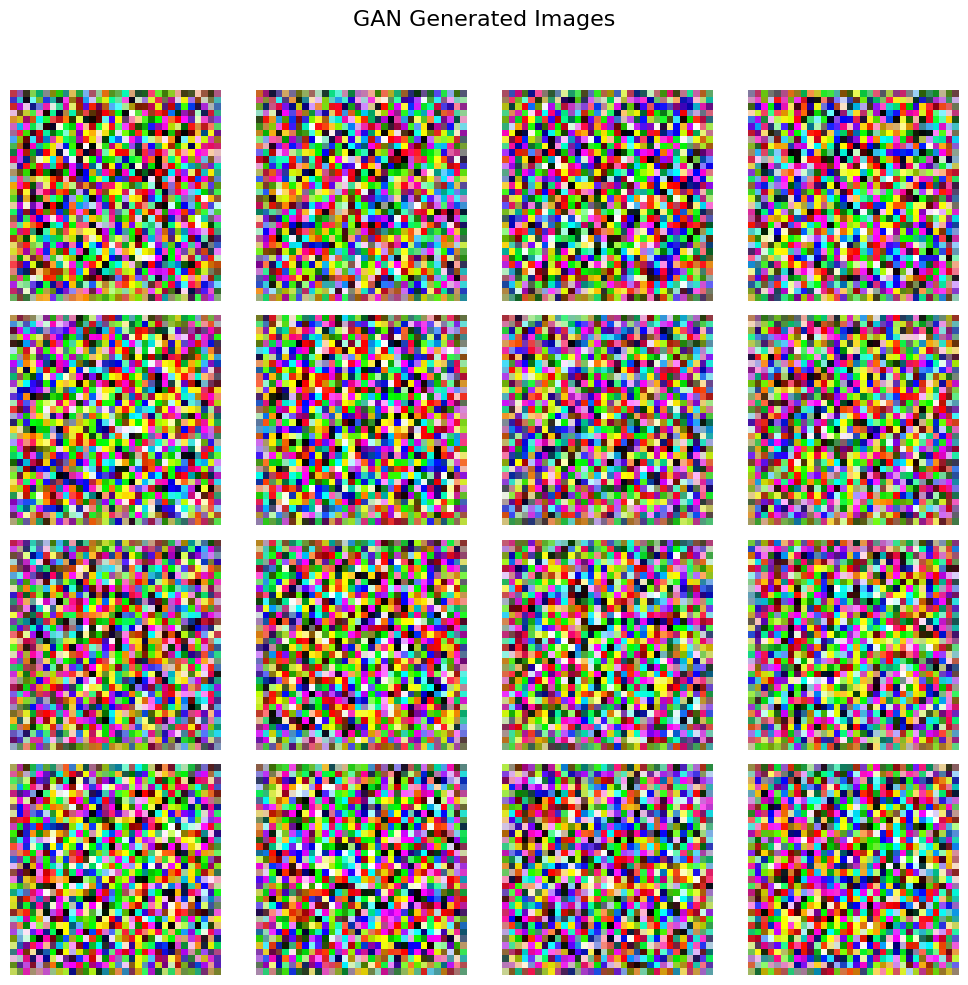

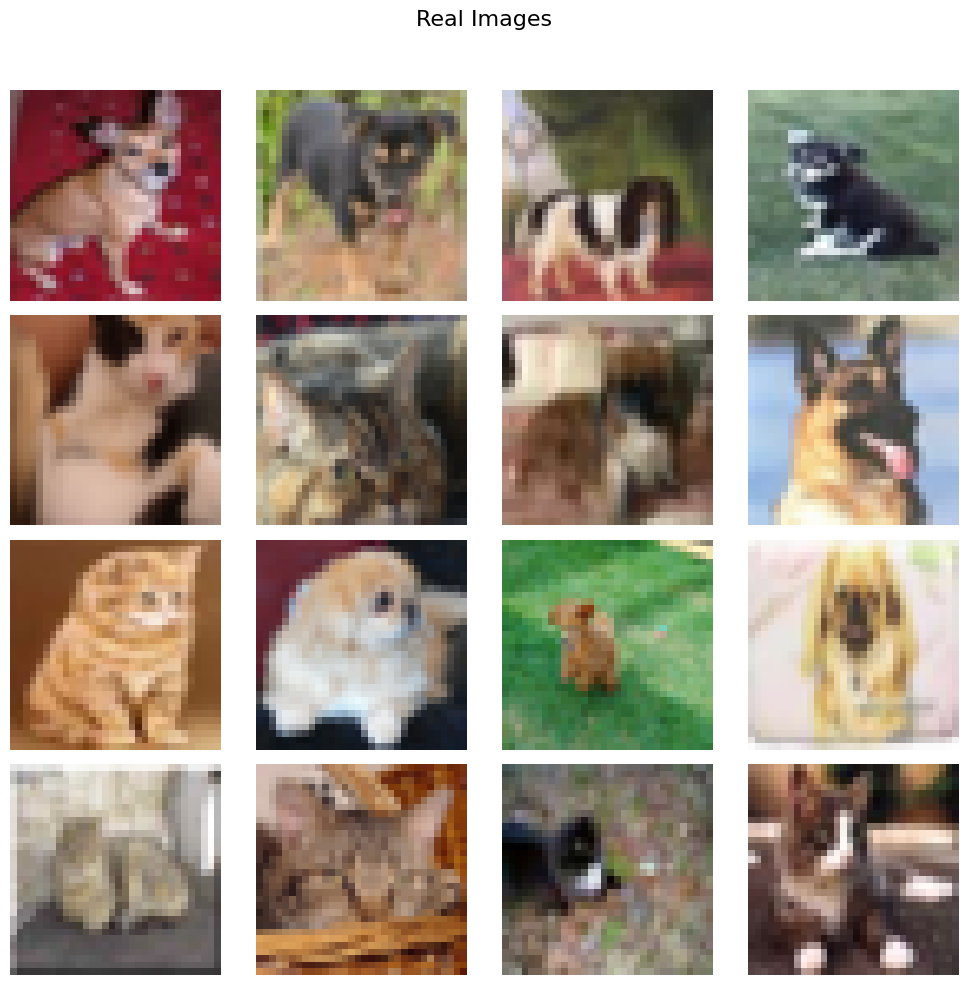

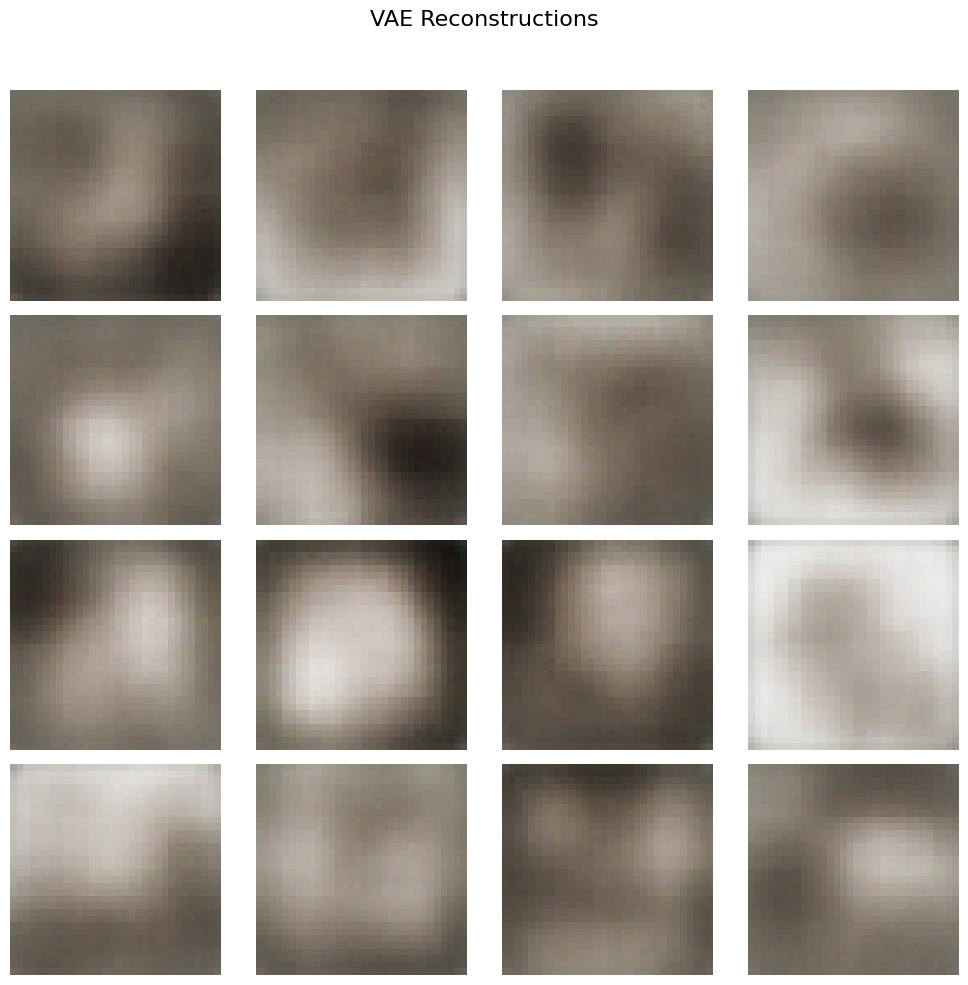

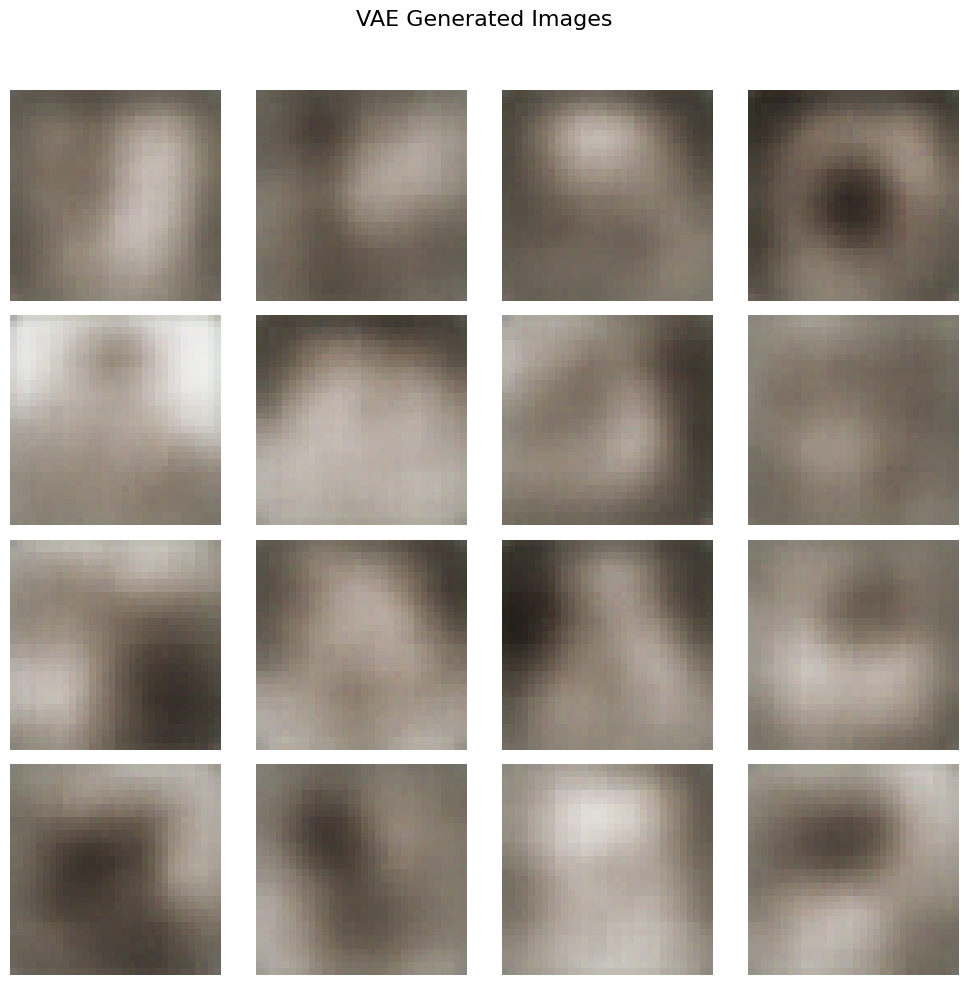

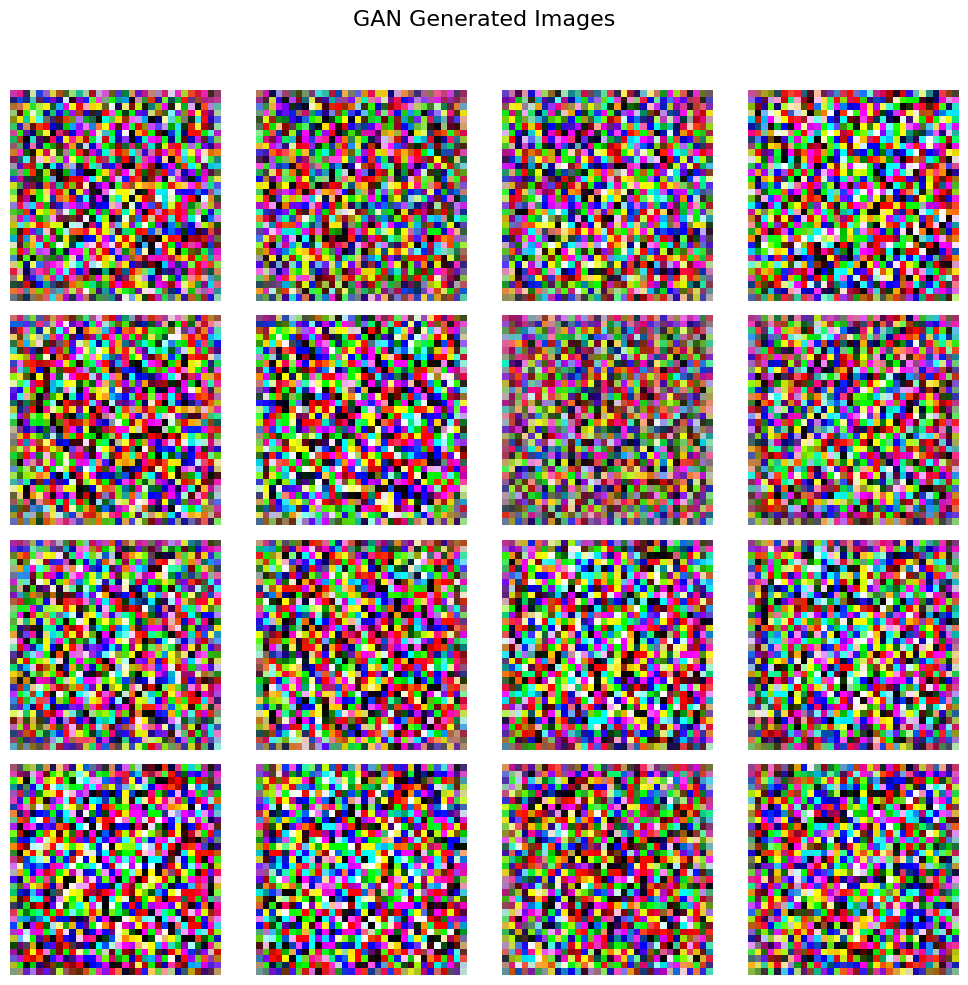

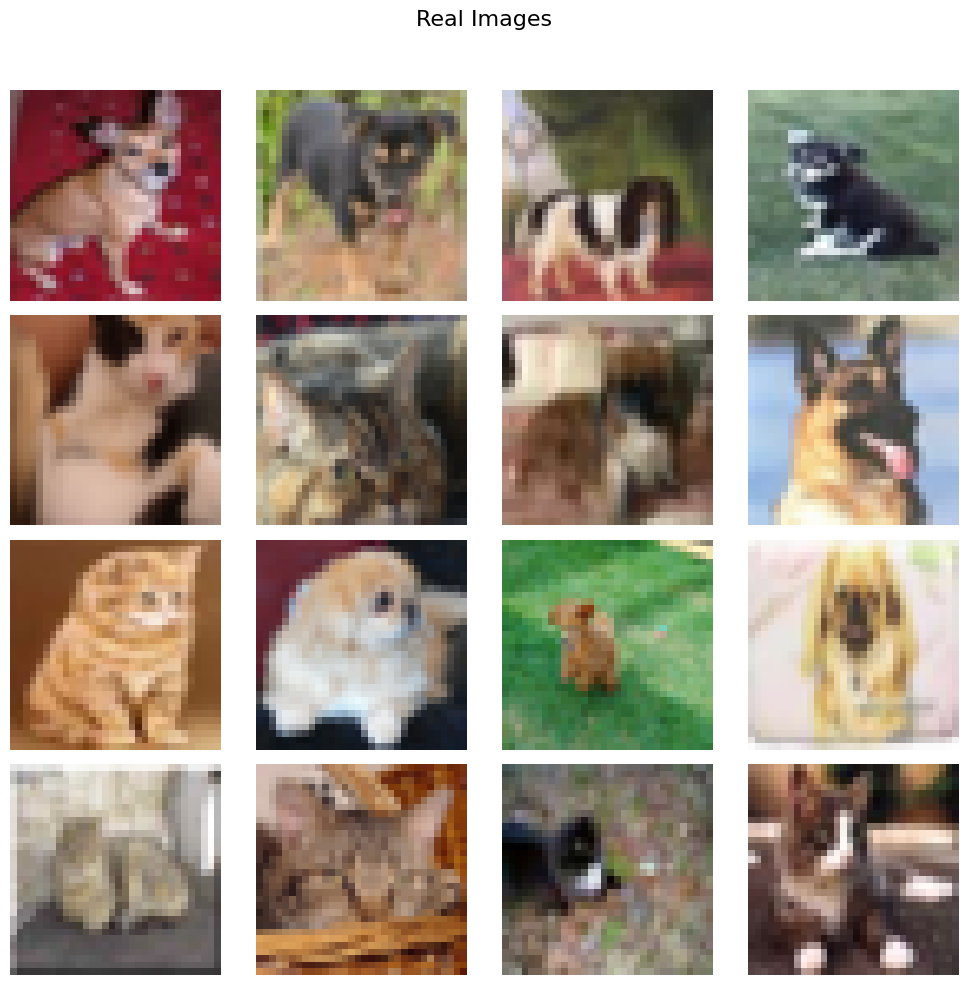

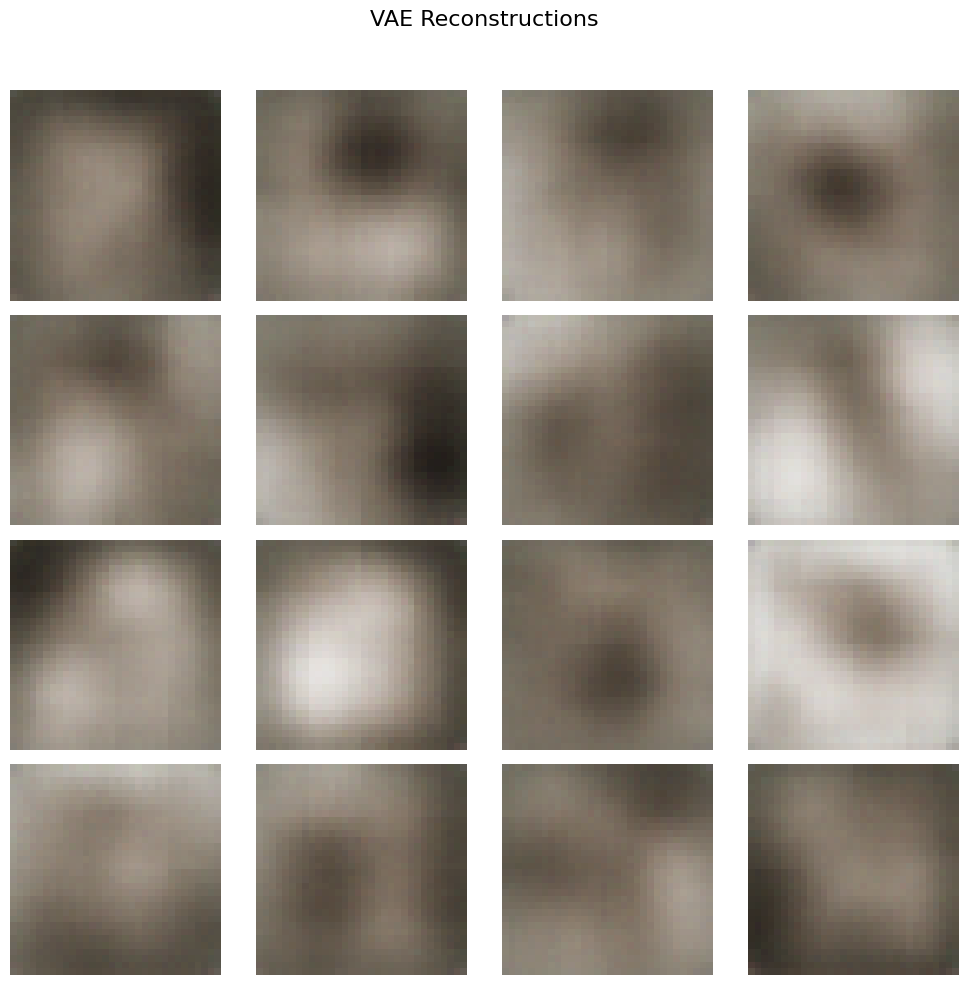

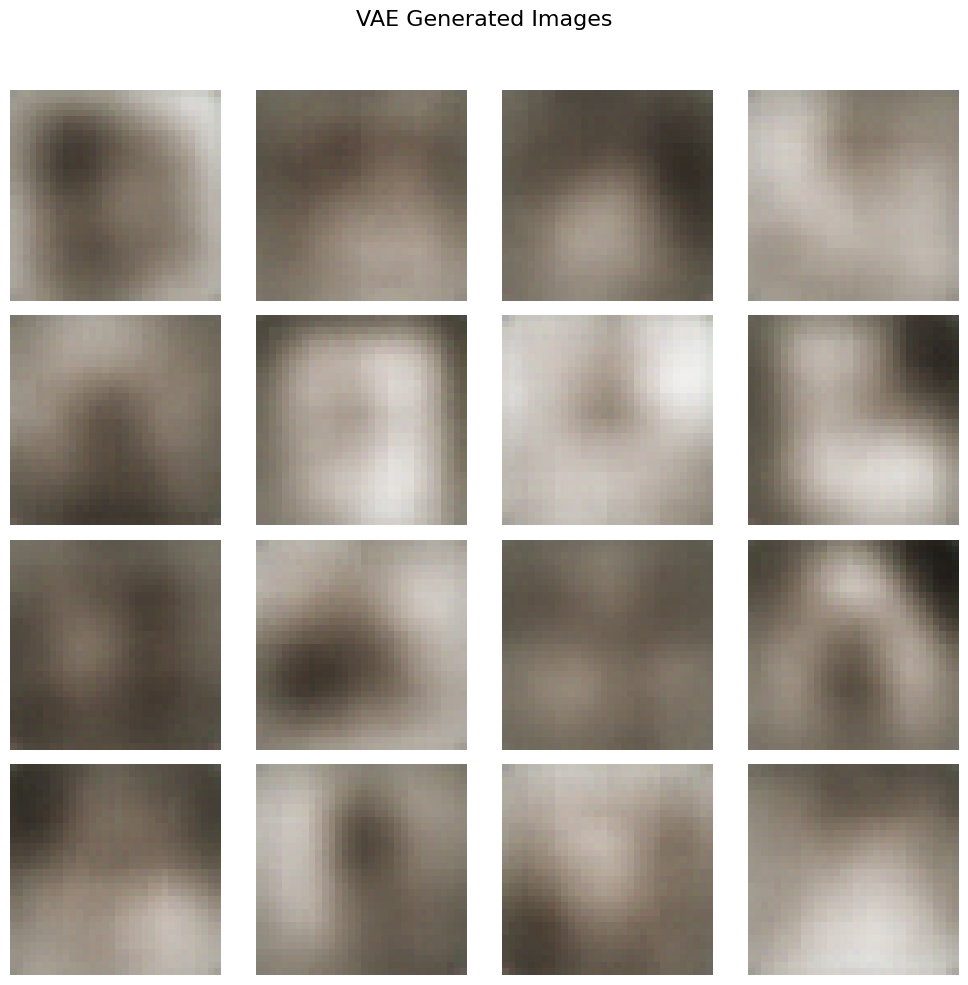

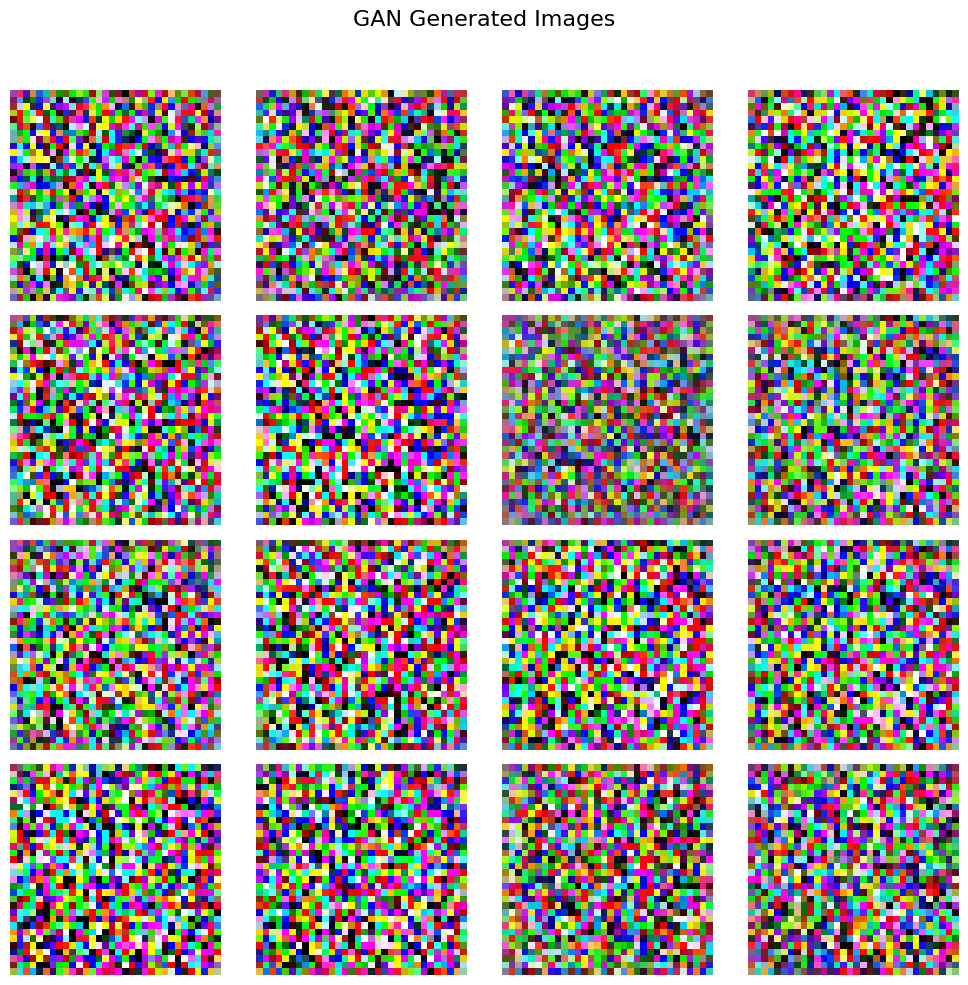

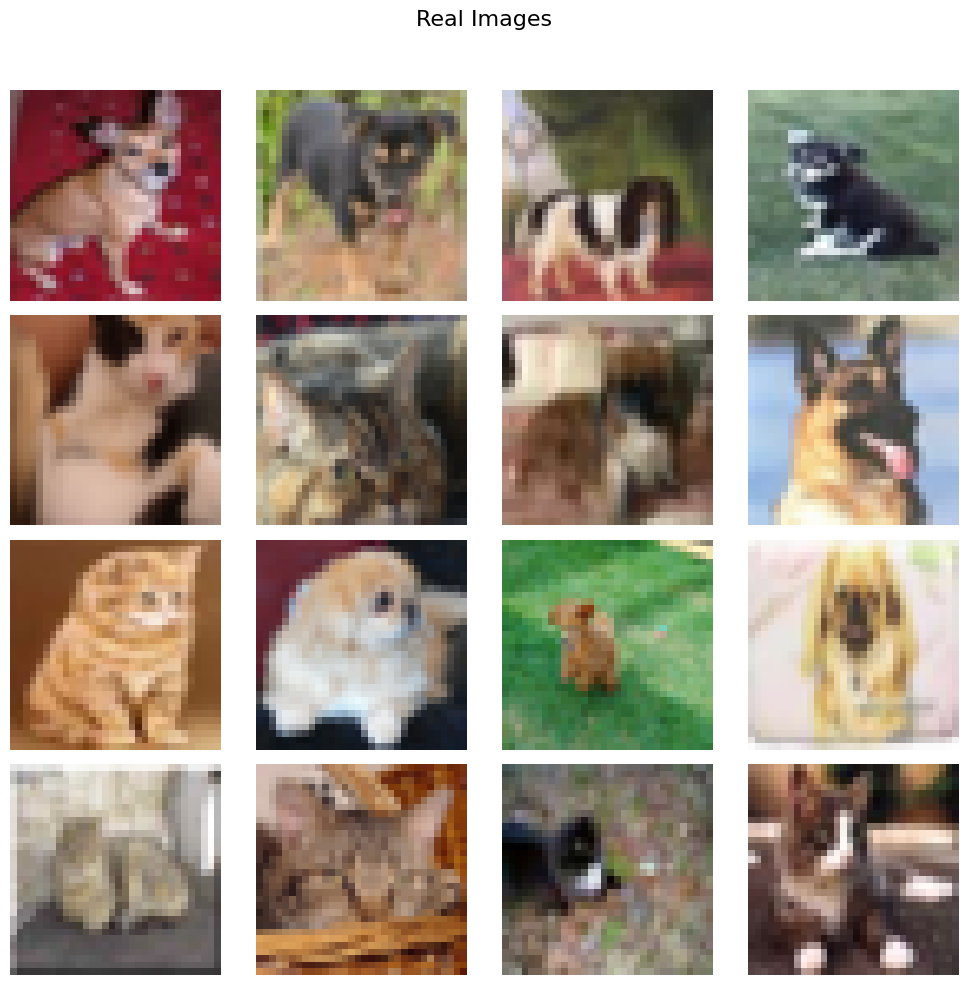

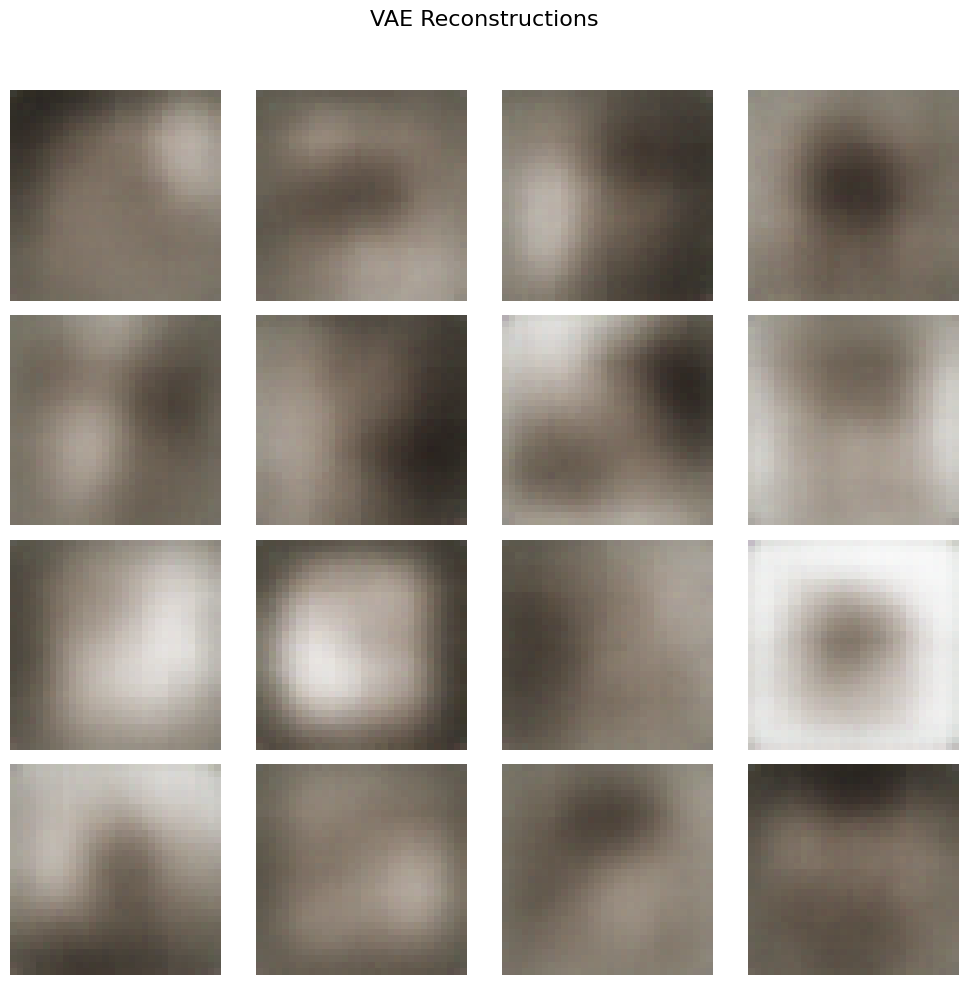

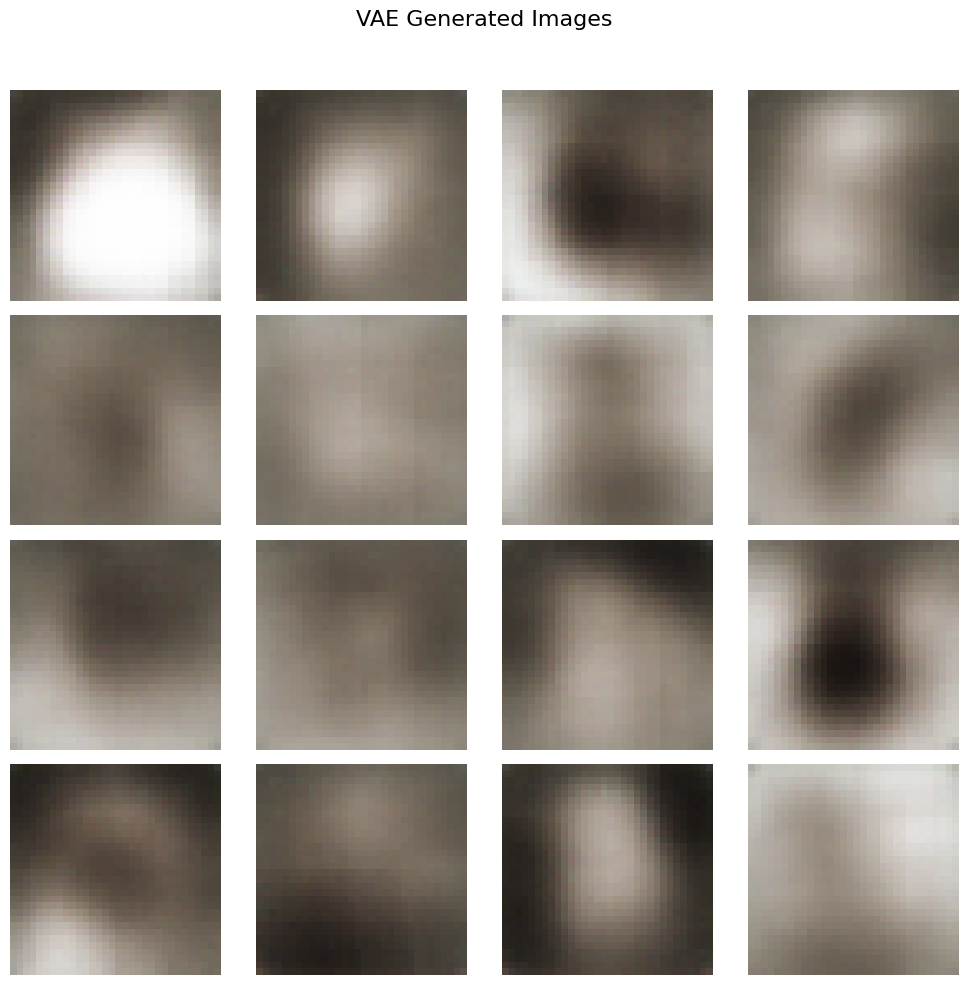

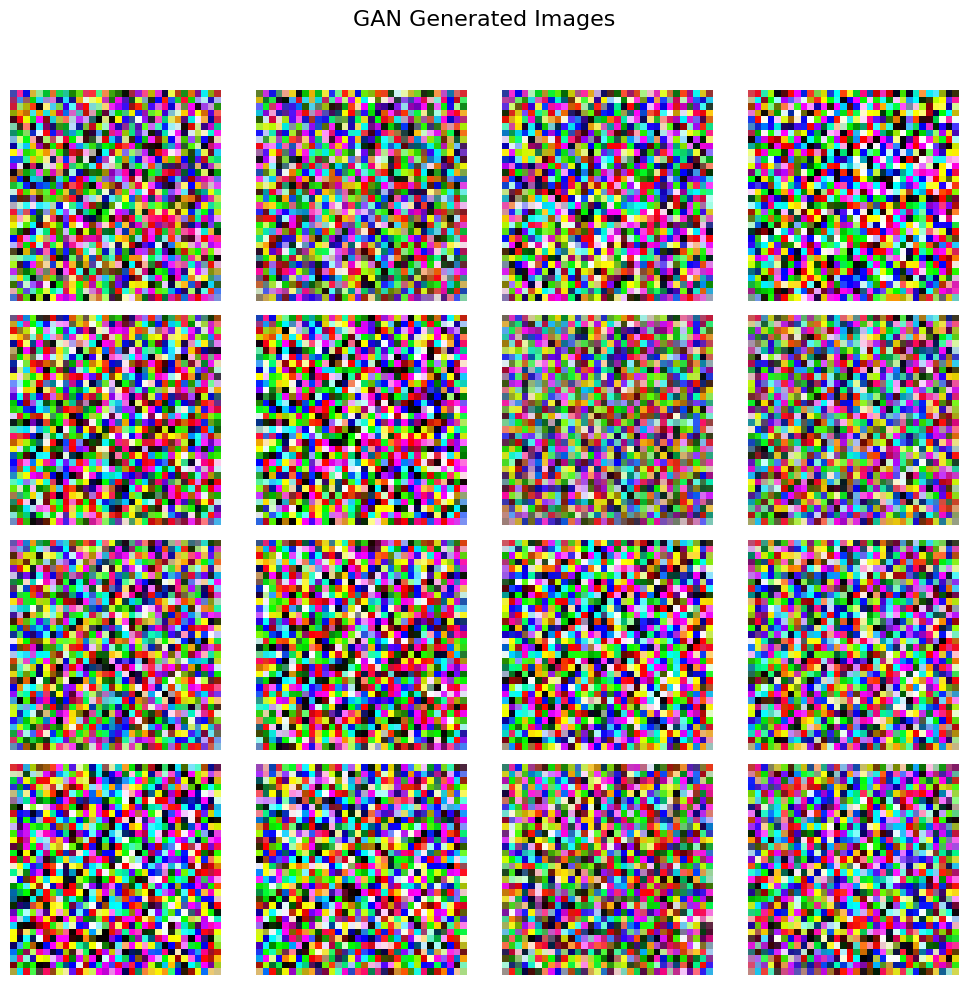

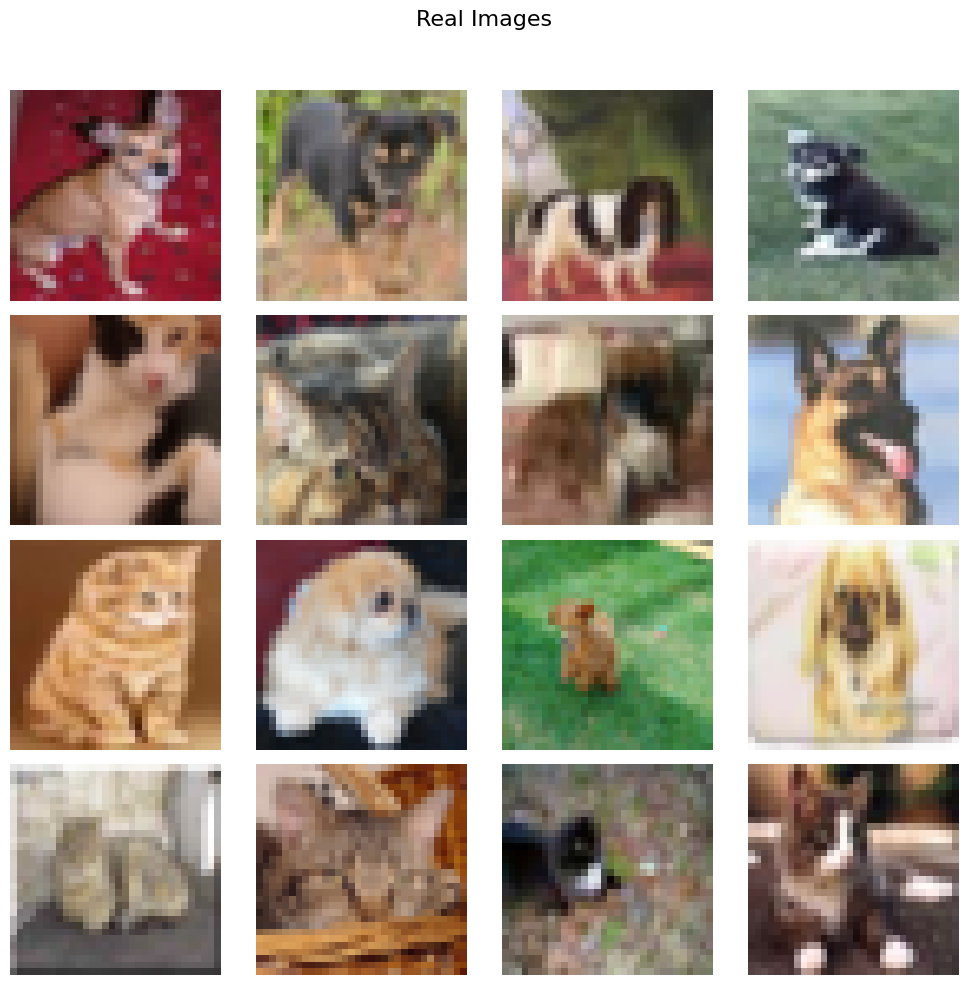

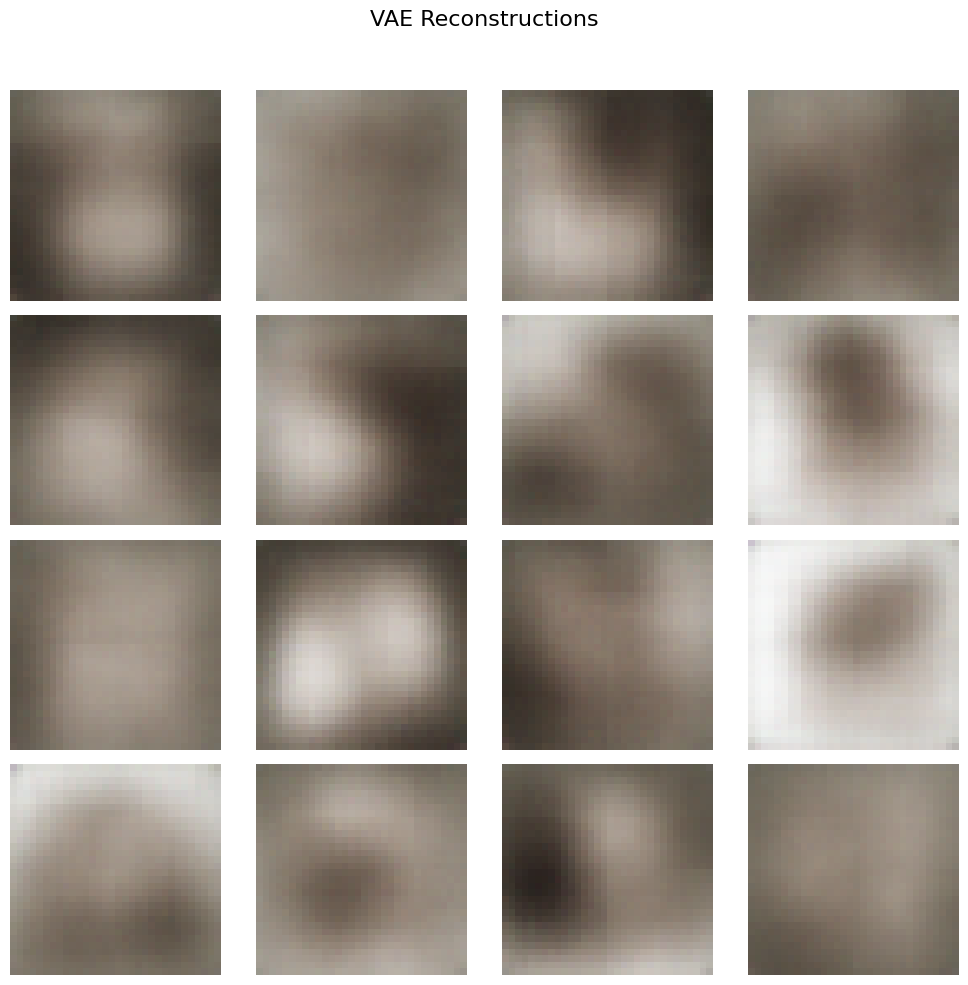

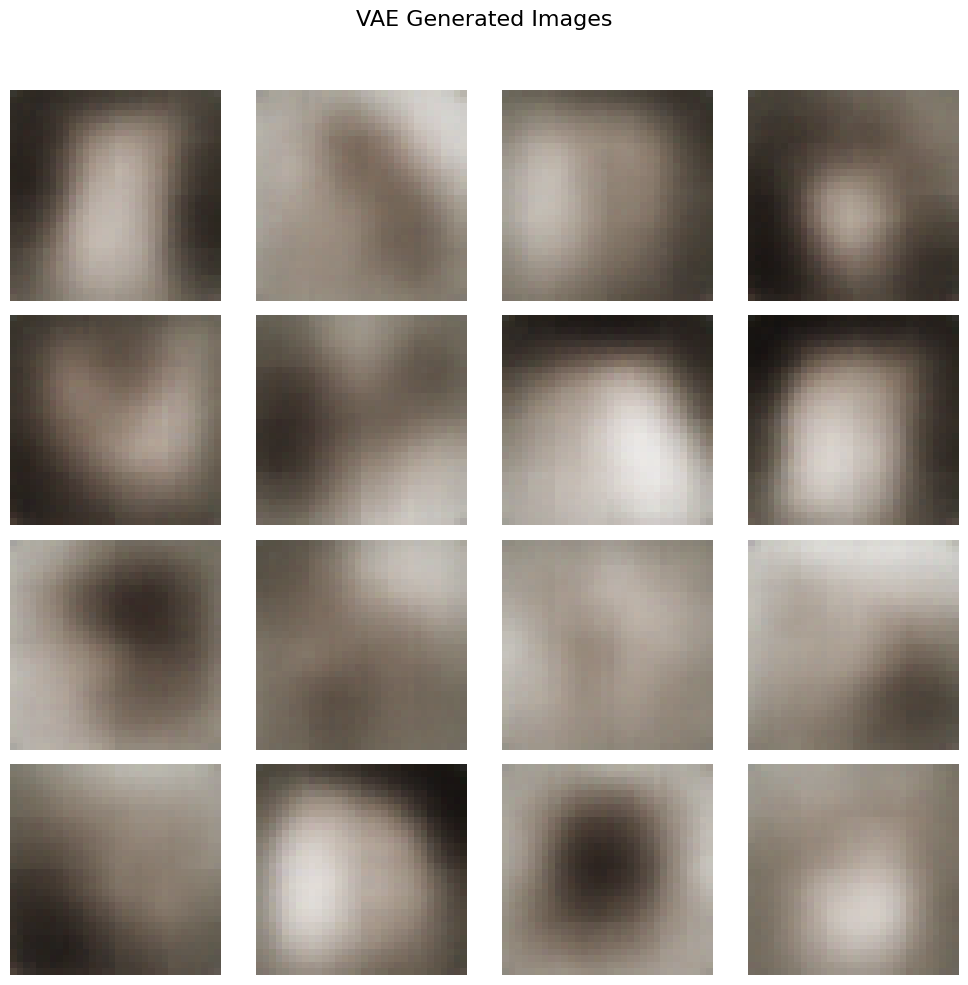

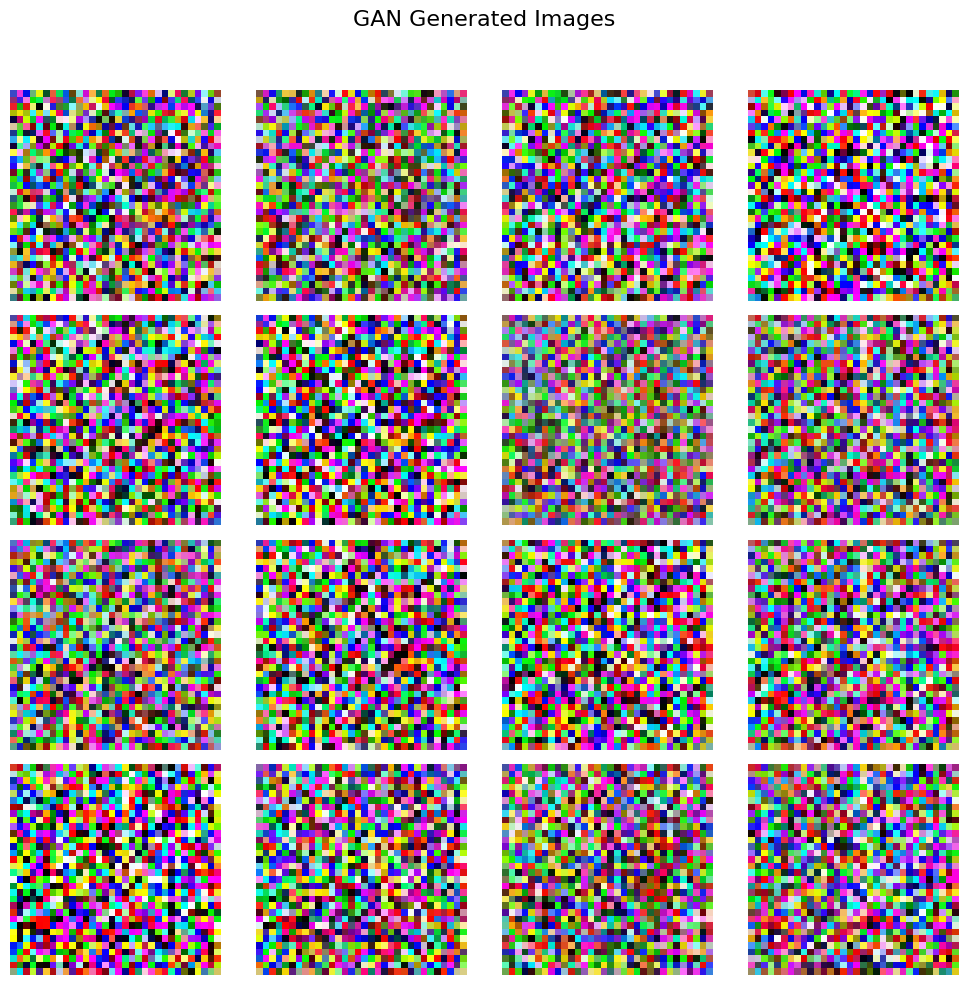

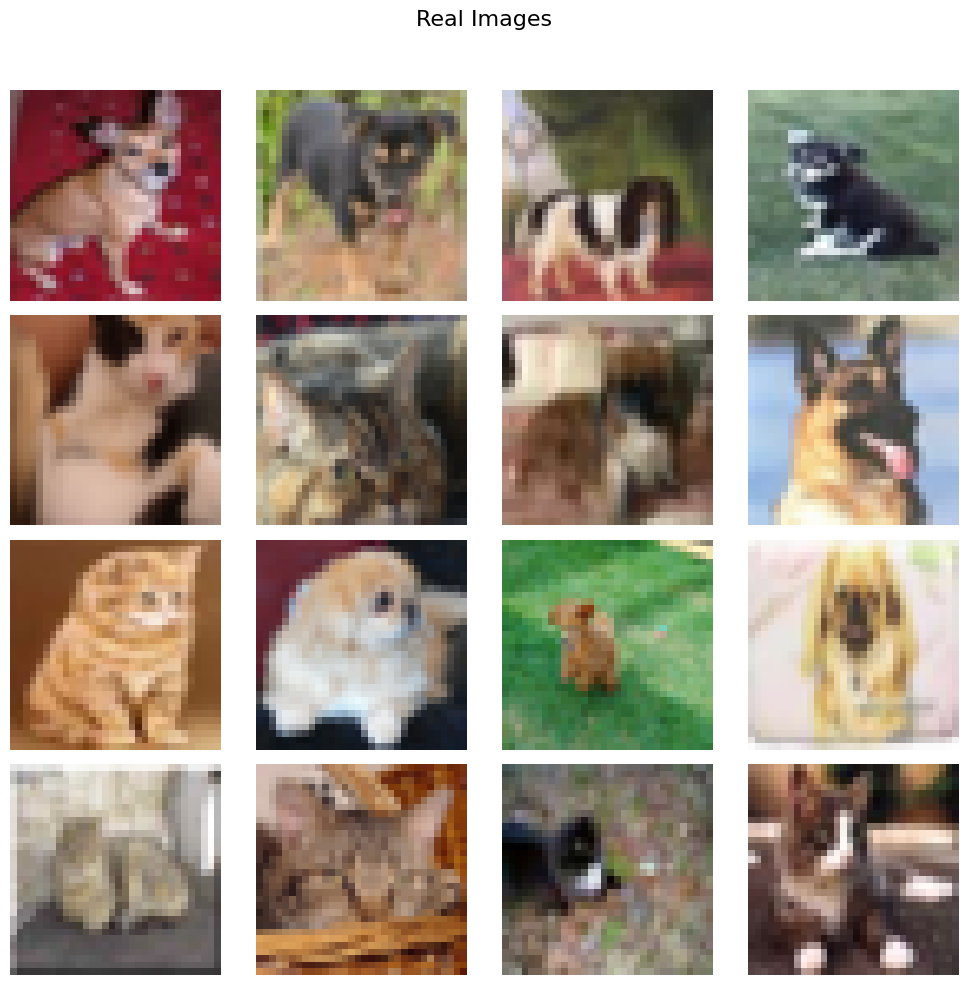

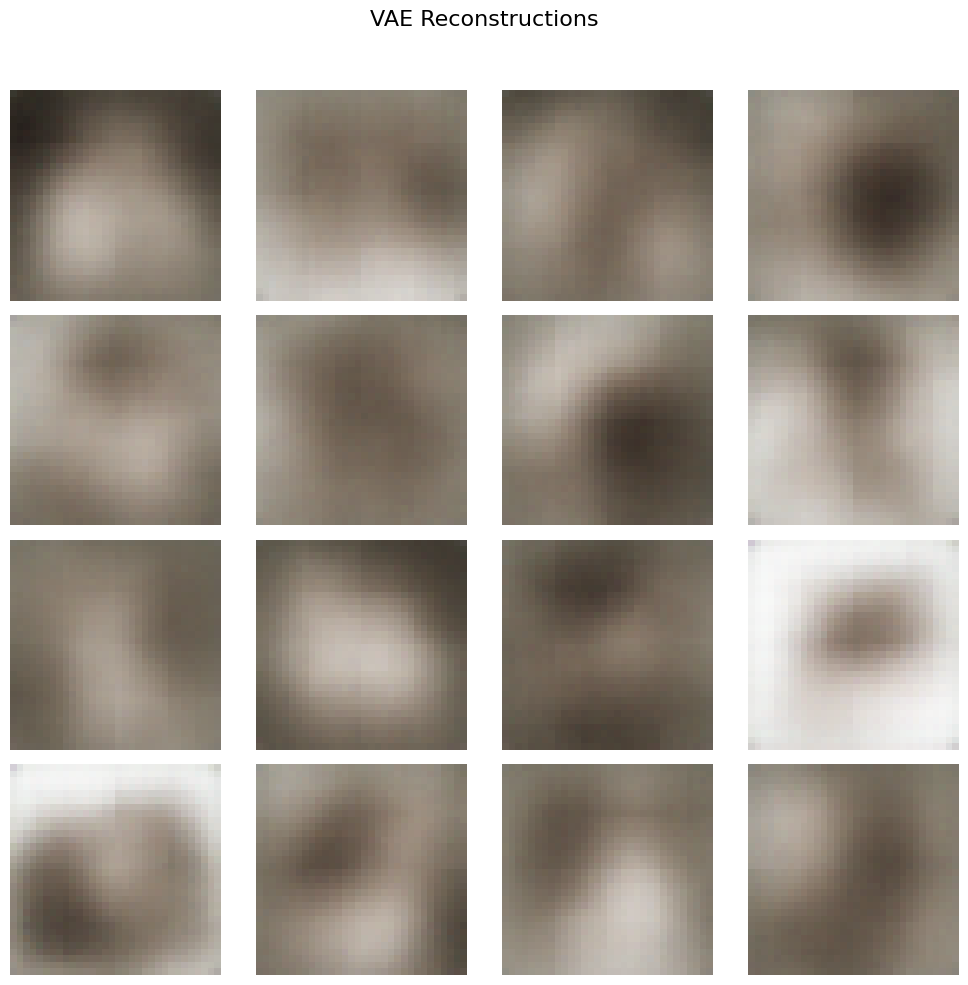

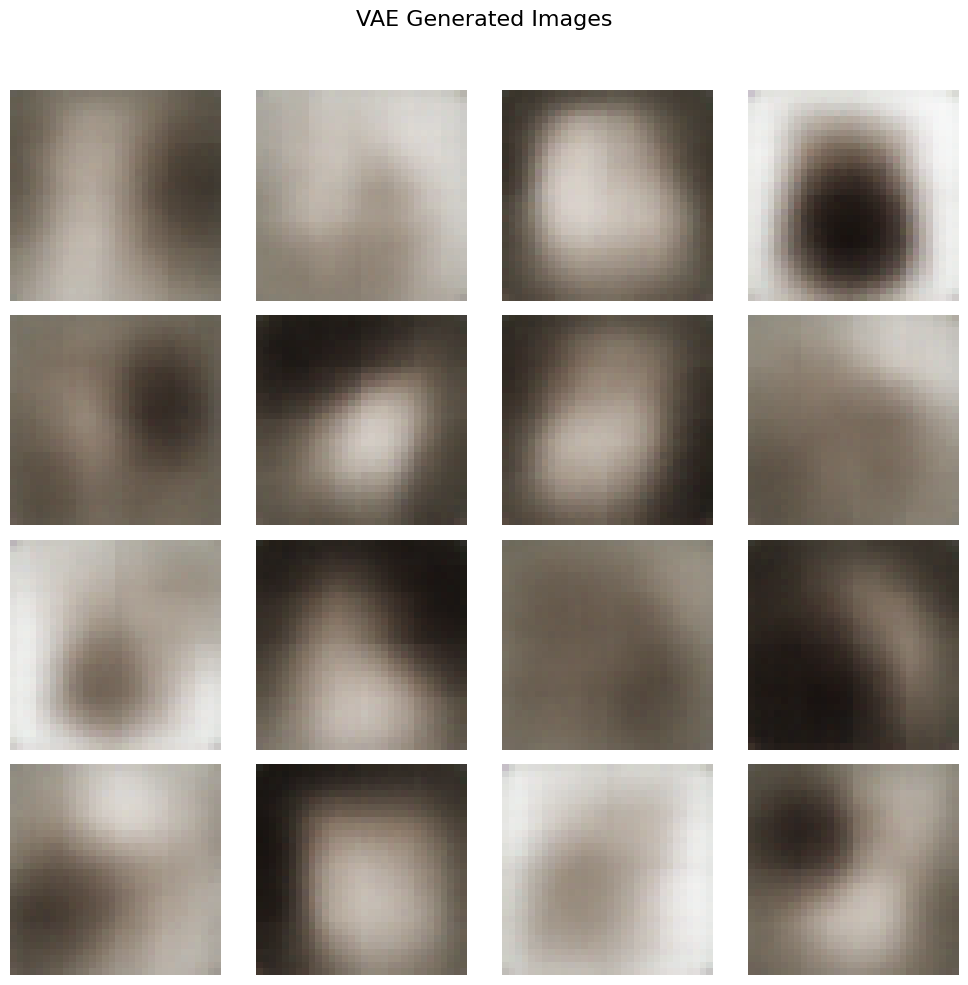

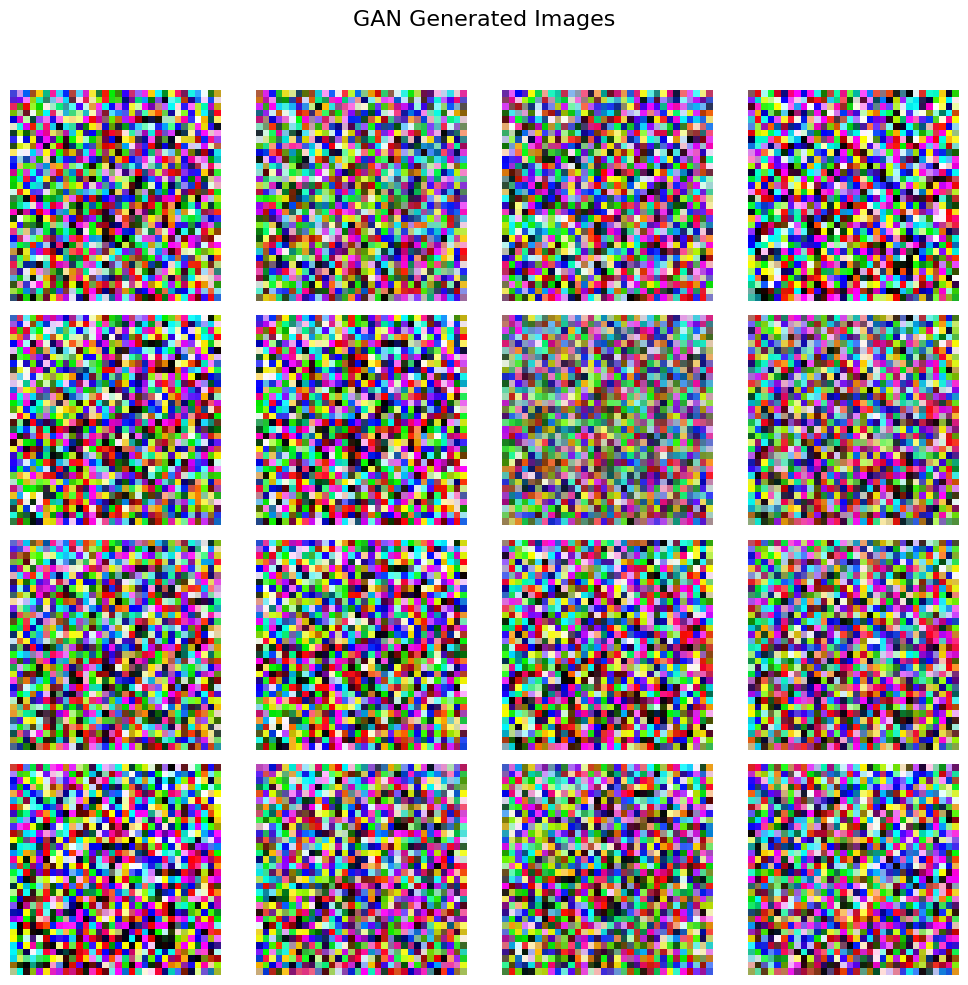

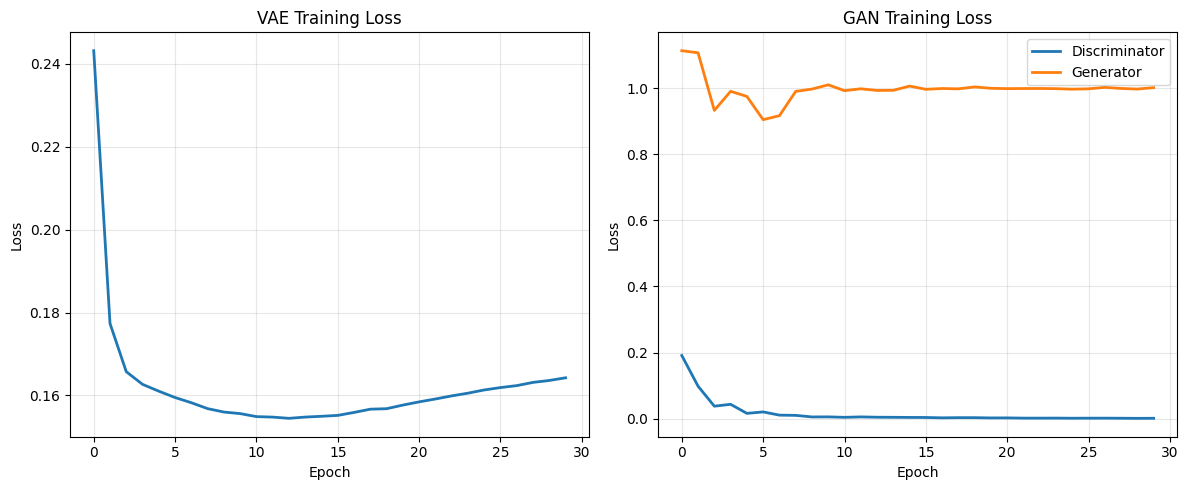


Quantitative Comparison:
VAE Reconstruction Loss: 0.1495
VAE KL Divergence: 0.0401
VAE Mean Squared Error: 0.0901
GAN Mean Squared Error: 0.1919
Same Image Similarity Score: -2.3689
Real-VAE Similarity Score: -2.1417
Real-GAN Similarity Score: -0.9906


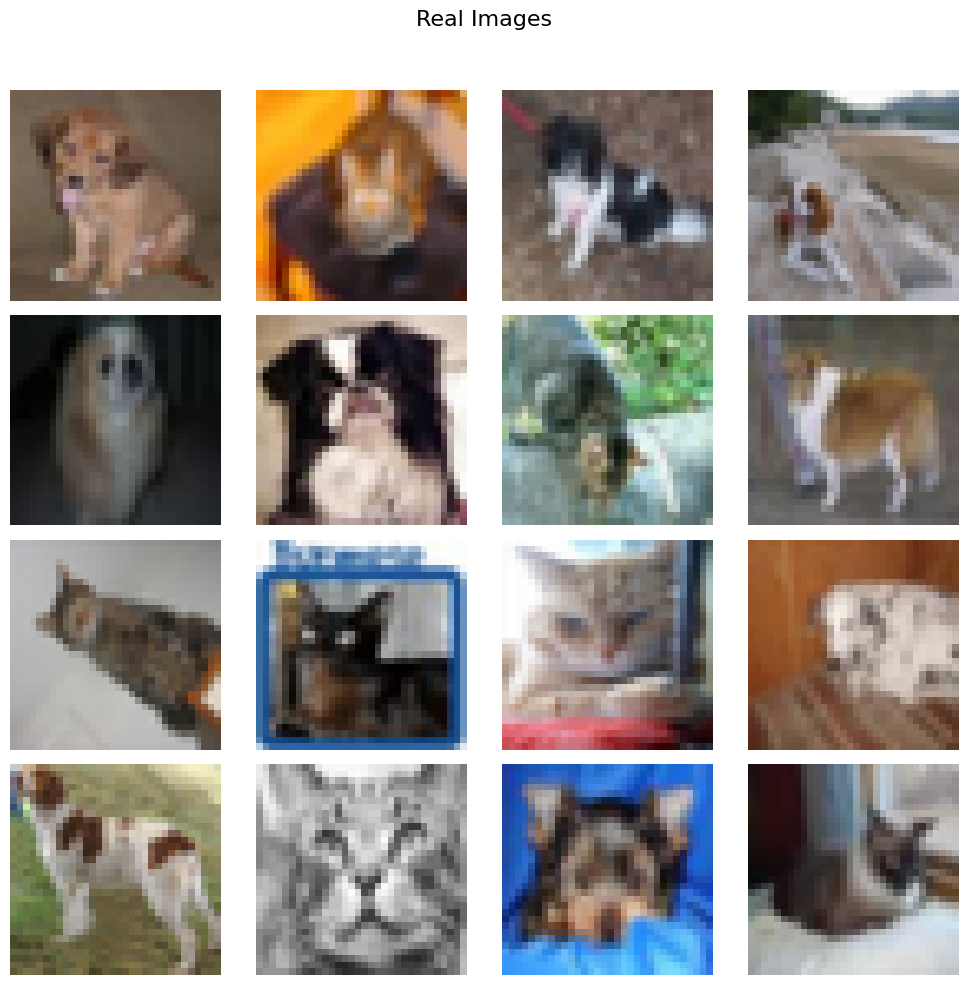

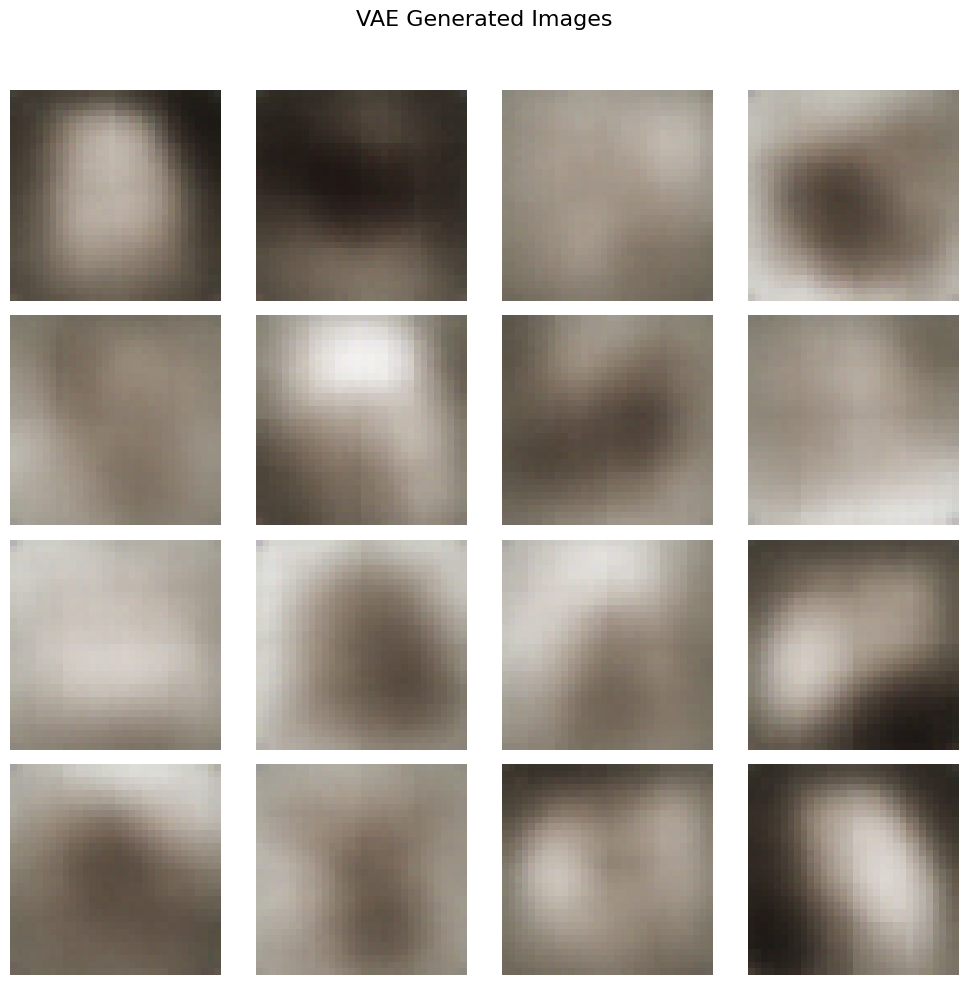

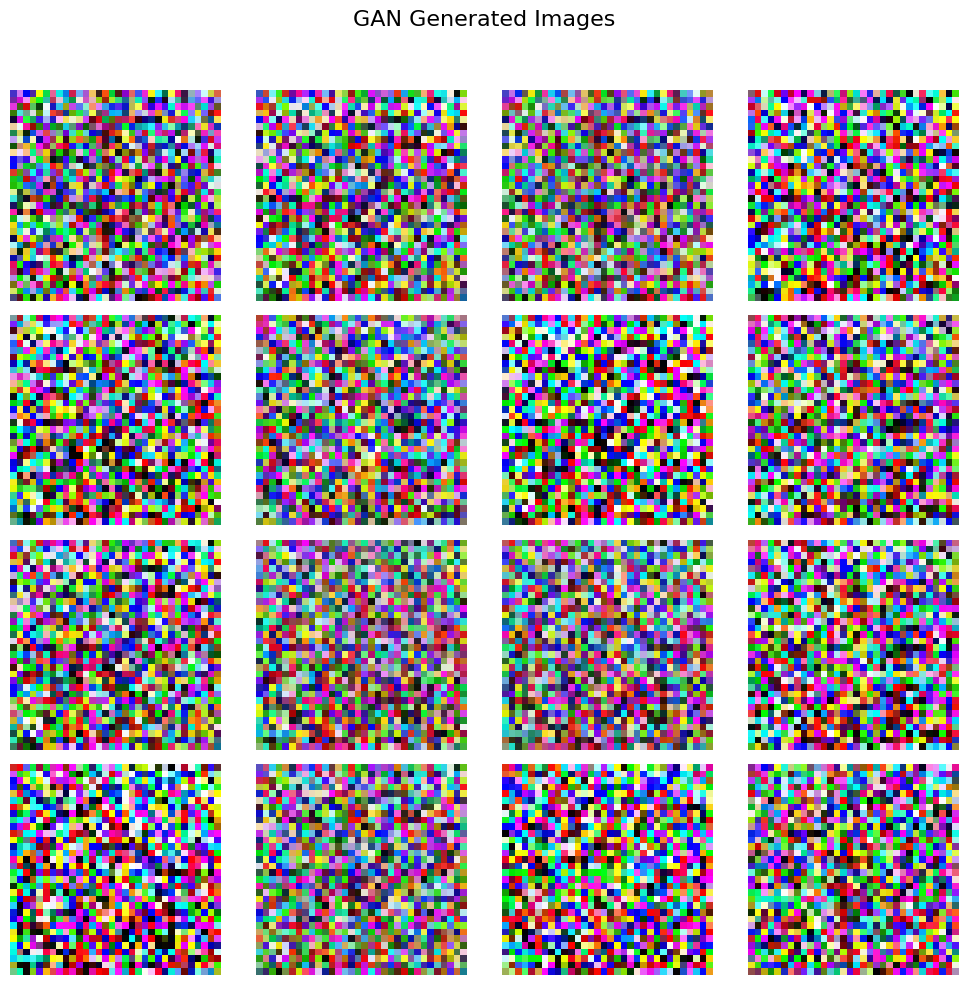

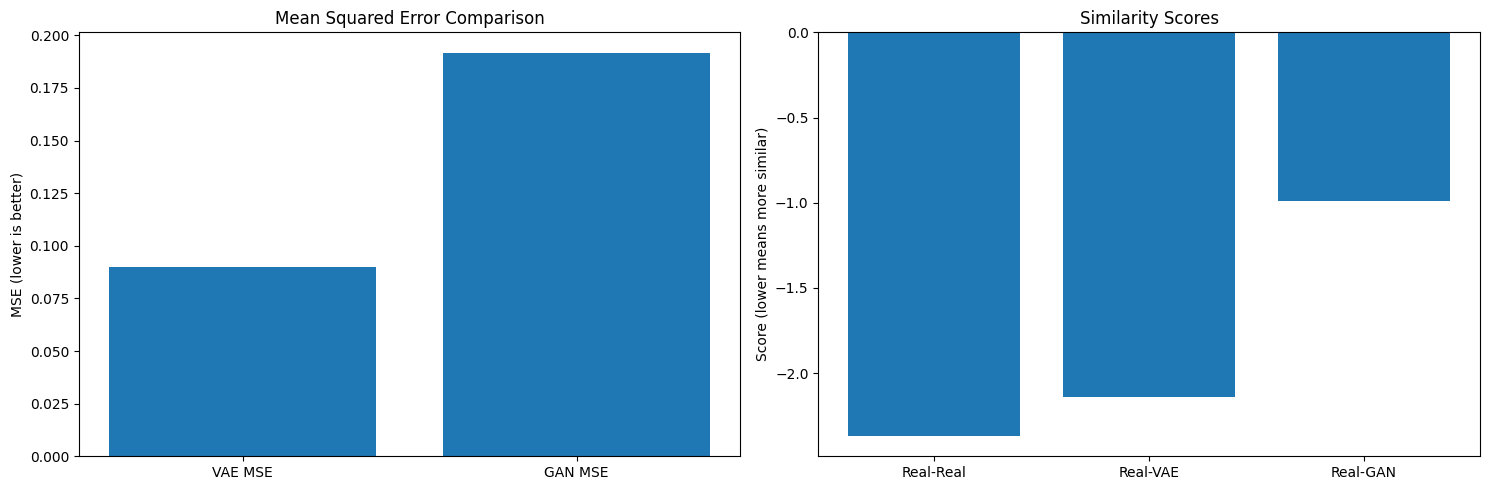

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Constants
BATCH_SIZE = 64
LATENT_DIM = 100
IMG_SHAPE = (32, 32, 3)
EPOCHS = 30
LEARNING_RATE = 1e-4

# Load CIFAR-10 data and filter cats (class 3) and dogs (class 5)
def load_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    # Filter cats (class 3) and dogs (class 5)
    cats_dogs_idx_train = np.where((y_train == 3) | (y_train == 5))[0]
    x_train_filtered = x_train[cats_dogs_idx_train]
    
    # Create binary labels (0 for cats, 1 for dogs)
    y_train_filtered = np.zeros(len(cats_dogs_idx_train))
    y_train_filtered[np.where(y_train[cats_dogs_idx_train] == 5)[0]] = 1
    
    # Normalize images to [-1, 1]
    x_train_filtered = (x_train_filtered.astype('float32') - 127.5) / 127.5
    
    return x_train_filtered, y_train_filtered

# VAE Model
class VAE(Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=IMG_SHAPE),
            layers.Conv2D(32, 4, strides=2, padding='same'),
            layers.LeakyReLU(0.2),
            layers.BatchNormalization(),
            
            layers.Conv2D(64, 4, strides=2, padding='same'),
            layers.LeakyReLU(0.2),
            layers.BatchNormalization(),
            
            layers.Conv2D(128, 4, strides=2, padding='same'),
            layers.LeakyReLU(0.2),
            layers.BatchNormalization(),
            
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dense(latent_dim * 2)  # Mean and log_var
        ])
        
        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(latent_dim,)),
            layers.Dense(4*4*128, activation='relu'),
            layers.Reshape((4, 4, 128)),
            
            layers.Conv2DTranspose(128, 4, strides=2, padding='same'),
            layers.LeakyReLU(0.2),
            layers.BatchNormalization(),
            
            layers.Conv2DTranspose(64, 4, strides=2, padding='same'),
            layers.LeakyReLU(0.2),
            layers.BatchNormalization(),
            
            layers.Conv2DTranspose(32, 4, strides=2, padding='same'),
            layers.LeakyReLU(0.2),
            layers.BatchNormalization(),
            
            layers.Conv2D(3, 3, padding='same', activation='tanh')
        ])
    
    def encode(self, x):
        mean_logvar = self.encoder(x)
        mean, logvar = tf.split(mean_logvar, num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(logvar * 0.5) * eps
        
    def decode(self, z):
        return self.decoder(z)
        
    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decode(z)
        return x_recon, mean, logvar
    
    def sample(self, num_samples):
        z = tf.random.normal(shape=(num_samples, self.latent_dim))
        return self.decode(z)

# Generator
def build_generator(latent_dim):
    model = tf.keras.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(4*4*256),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),
        layers.Reshape((4, 4, 256)),
        
        layers.Conv2DTranspose(128, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),
        
        layers.Conv2DTranspose(64, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),
        
        layers.Conv2DTranspose(32, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),
        
        layers.Conv2D(3, 3, padding='same', activation='tanh')
    ])
    return model

# Feature extraction for similarity network
def build_feature_extractor():
    model = tf.keras.Sequential([
        layers.Input(shape=IMG_SHAPE),
        layers.Conv2D(64, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(128, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(256, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        
        layers.Flatten(),
        layers.Dense(512)
    ])
    return model

# Minibatch discrimination layer for diversity promotion
class MinibatchDiscrimination(layers.Layer):
    def __init__(self, nb_kernels, kernel_dim):
        super(MinibatchDiscrimination, self).__init__()
        self.nb_kernels = nb_kernels
        self.kernel_dim = kernel_dim
        
    def build(self, input_shape):
        self.kernel = self.add_weight(
            name='kernel',
            shape=(input_shape[1], self.nb_kernels * self.kernel_dim),
            initializer='glorot_uniform',
            trainable=True
        )
        
    def call(self, x):
        activation = K.dot(x, self.kernel)
        activation = K.reshape(activation, (-1, self.nb_kernels, self.kernel_dim))
        
        # Calculate L1 distance between samples
        expanded_a = K.expand_dims(activation, 1)
        expanded_b = K.expand_dims(activation, 0)
        norm = K.sum(K.abs(expanded_a - expanded_b), axis=3)
        
        # Apply negative exponential
        exp = K.exp(-norm)
        
        # Sum over samples
        result = K.sum(exp, axis=1)
        return K.concatenate([x, result], axis=1)

# Siamese-like similarity discriminator
def build_similarity_discriminator():
    # Shared feature extractor
    feature_extractor = build_feature_extractor()
    
    # Input for real and generated images
    real_input = Input(shape=IMG_SHAPE)
    fake_input = Input(shape=IMG_SHAPE)
    
    # Extract features
    real_features = feature_extractor(real_input)
    fake_features = feature_extractor(fake_input)
    
    # Minibatch discrimination for diversity promotion
    real_with_minibatch = MinibatchDiscrimination(5, 3)(real_features)
    fake_with_minibatch = MinibatchDiscrimination(5, 3)(fake_features)
    
    # Concatenate features
    merged_features = layers.Concatenate()([real_with_minibatch, fake_with_minibatch])
    
    # Similarity network
    x = layers.Dense(256)(merged_features)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dense(1)(x)  # No activation function

    
    return Model([real_input, fake_input], x)

# VAE Loss Function
def vae_loss(x, x_recon, mean, logvar, beta=0.5):
    recon_loss = tf.reduce_mean(tf.square(x - x_recon))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return recon_loss + beta * kl_loss, recon_loss, kl_loss

# Similarity loss for GAN
def similarity_loss(real_fake_similarity):
    # Discriminator aims to maximize dissimilarity (higher score)
    return -tf.reduce_mean(real_fake_similarity) + 0.001 * tf.reduce_mean(tf.square(real_fake_similarity))

def generator_similarity_loss(real_fake_similarity):
    # Generator aims to minimize dissimilarity (lower score)
    return tf.reduce_mean(real_fake_similarity)

# Training functions
@tf.function
def train_vae_step(model, x, optimizer, beta=0.5):
    with tf.GradientTape() as tape:
        x_recon, mean, logvar = model(x)
        loss, recon_loss, kl_loss = vae_loss(x, x_recon, mean, logvar, beta)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, recon_loss, kl_loss

@tf.function
def train_gan_step(real_images, generator, discriminator, gen_optimizer, disc_optimizer, latent_dim):
    batch_size = tf.shape(real_images)[0]
    
    # Train discriminator
    noise = tf.random.normal([batch_size, latent_dim])
    with tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        # Calculate similarity between real and fake images
        real_fake_similarity = discriminator([real_images, generated_images], training=True)
        
        # Apply label smoothing here
        target_neg_ones = -tf.ones_like(real_fake_similarity) * 0.9  # Instead of -1.0
        
        # Modified discriminator loss with label smoothing
        disc_loss = tf.reduce_mean(tf.square(real_fake_similarity - target_neg_ones))
        # Or alternatively: disc_loss = similarity_loss(real_fake_similarity)
    
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    disc_gradients, _ = tf.clip_by_global_norm(disc_gradients, 1.0)
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
    
    # Train generator
    noise = tf.random.normal([batch_size, latent_dim])
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        
        # Calculate similarity between real and fake images
        real_fake_similarity = discriminator([real_images, generated_images], training=True)
        
        # Apply label smoothing here
        target_zeros = tf.zeros_like(real_fake_similarity) + 0.1  # Instead of 0.0
        
        # Modified generator loss with label smoothing
        gen_loss = tf.reduce_mean(tf.square(real_fake_similarity - target_zeros))
        # Or alternatively: gen_loss = generator_similarity_loss(real_fake_similarity)
    
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_gradients, _ = tf.clip_by_global_norm(gen_gradients, 1.0)
    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    
    return disc_loss, gen_loss

# Display images utility
def display_images(images, title=None, rows=4, cols=4):
    images = (images + 1) / 2.0  # Rescale to [0, 1]
    
    plt.figure(figsize=(10, 10))
    for i in range(min(rows*cols, len(images))):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    
    if title:
        plt.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

# Main training function
def train_models(dataset, epochs):
    vae_losses = []
    gan_d_losses = []
    gan_g_losses = []
    
    # Fixed noise for visualization
    sample_noise = tf.random.normal([16, LATENT_DIM])
    sample_real_images = next(iter(dataset.take(1)))[:16]
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        epoch_vae_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0
        epoch_gan_d_loss = 0
        epoch_gan_g_loss = 0
        batches = 0
        
        # Adaptive beta for KL term
        beta = min(1.0, 0.2 + epoch * 0.02)
        
        for batch in dataset:
            # Train VAE
            vae_loss_val, recon_loss, kl_loss = train_vae_step(vae, batch, vae_optimizer, beta)
            
            # Train GAN
            d_loss, g_loss = train_gan_step(batch, generator, similarity_discriminator, 
                                          generator_optimizer, discriminator_optimizer, LATENT_DIM)
            
            # Update metrics
            epoch_vae_loss += vae_loss_val
            epoch_recon_loss += recon_loss
            epoch_kl_loss += kl_loss
            epoch_gan_d_loss += d_loss
            epoch_gan_g_loss += g_loss
            batches += 1
            
        # Average losses
        epoch_vae_loss /= batches
        epoch_gan_d_loss /= batches
        epoch_gan_g_loss /= batches
        
        # Record losses
        vae_losses.append(epoch_vae_loss.numpy())
        gan_d_losses.append(epoch_gan_d_loss.numpy())
        gan_g_losses.append(epoch_gan_g_loss.numpy())
        
        print(f"VAE Loss: {epoch_vae_loss:.4f}, GAN D Loss: {epoch_gan_d_loss:.4f}, GAN G Loss: {epoch_gan_g_loss:.4f}")
        
        # Visualize results every 5 epochs
        if (epoch + 1) % 5 == 0:
            # VAE reconstructions
            x_recon, _, _ = vae(sample_real_images)
            
            # Generate samples
            vae_samples = vae.sample(16)
            gan_samples = generator(sample_noise, training=False)
            
            # Display results
            display_images(sample_real_images.numpy(), "Real Images")
            display_images(x_recon.numpy(), "VAE Reconstructions")
            display_images(vae_samples.numpy(), "VAE Generated Images")
            display_images(gan_samples.numpy(), "GAN Generated Images")
    
    return vae_losses, gan_d_losses, gan_g_losses

# Compare models quantitatively
def compare_models(dataset, vae, generator, similarity_discriminator):
    # Get samples
    real_batch = next(iter(dataset.take(1)))[:32]
    vae_samples = vae.sample(32)
    
    noise = tf.random.normal([32, LATENT_DIM])
    gan_samples = generator(noise, training=False)
    
    # VAE metrics
    x_recon, mean, logvar = vae(real_batch)
    total_loss, recon_loss, kl_loss = vae_loss(real_batch, x_recon, mean, logvar)
    
    # GAN metrics - similarity scores
    real_real_similarity = similarity_discriminator([real_batch, real_batch])
    real_vae_similarity = similarity_discriminator([real_batch, vae_samples])
    real_gan_similarity = similarity_discriminator([real_batch, gan_samples])
    
    # Calculate MSE
    def calculate_mse(real_imgs, gen_imgs):
        real_norm = (real_imgs + 1) / 2
        gen_norm = (gen_imgs + 1) / 2
        return tf.reduce_mean(tf.square(real_norm - gen_norm))
    
    vae_mse = calculate_mse(real_batch, vae_samples)
    gan_mse = calculate_mse(real_batch, gan_samples)
    
    # Display results
    print("\nQuantitative Comparison:")
    print(f"VAE Reconstruction Loss: {recon_loss:.4f}")
    print(f"VAE KL Divergence: {kl_loss:.4f}")
    print(f"VAE Mean Squared Error: {vae_mse:.4f}")
    print(f"GAN Mean Squared Error: {gan_mse:.4f}")
    print(f"Same Image Similarity Score: {tf.reduce_mean(real_real_similarity):.4f}")
    print(f"Real-VAE Similarity Score: {tf.reduce_mean(real_vae_similarity):.4f}")
    print(f"Real-GAN Similarity Score: {tf.reduce_mean(real_gan_similarity):.4f}")
    
    # Visual comparison
    display_images(real_batch.numpy(), "Real Images", rows=4, cols=4)
    display_images(vae_samples.numpy(), "VAE Generated Images", rows=4, cols=4)
    display_images(gan_samples.numpy(), "GAN Generated Images", rows=4, cols=4)
    
    # Plot losses
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.bar(['VAE MSE', 'GAN MSE'], [vae_mse.numpy(), gan_mse.numpy()])
    plt.title('Mean Squared Error Comparison')
    plt.ylabel('MSE (lower is better)')
    
    plt.subplot(1, 2, 2)
    plt.bar(['Real-Real', 'Real-VAE', 'Real-GAN'], 
            [tf.reduce_mean(real_real_similarity).numpy(), 
             tf.reduce_mean(real_vae_similarity).numpy(), 
             tf.reduce_mean(real_gan_similarity).numpy()])
    plt.title('Similarity Scores')
    plt.ylabel('Score (lower means more similar)')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'vae_recon_loss': recon_loss.numpy(),
        'vae_kl_loss': kl_loss.numpy(),
        'vae_mse': vae_mse.numpy(),
        'gan_mse': gan_mse.numpy(),
        'real_real_similarity': tf.reduce_mean(real_real_similarity).numpy(),
        'real_vae_similarity': tf.reduce_mean(real_vae_similarity).numpy(),
        'real_gan_similarity': tf.reduce_mean(real_gan_similarity).numpy()
    }

# Plot loss function
def plot_losses(vae_losses, gan_d_losses, gan_g_losses):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(vae_losses, linewidth=2, label='VAE Loss')
    plt.title('VAE Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(gan_d_losses, linewidth=2, label='Discriminator')
    plt.plot(gan_g_losses, linewidth=2, label='Generator')
    plt.title('GAN Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load data
    x_train_filtered, y_train_filtered = load_data()
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices(x_train_filtered)
    dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE)
    
    # Create models
    vae = VAE(LATENT_DIM)
    generator = build_generator(LATENT_DIM)
    similarity_discriminator = build_similarity_discriminator()
    
    # Create optimizers
    vae_optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=0.5, beta_2=0.9)
    generator_optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=0.5, beta_2=0.9)
    discriminator_optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=0.5, beta_2=0.9)
    
    # Train models
    vae_losses, gan_d_losses, gan_g_losses = train_models(dataset, EPOCHS)
    
    # Plot training losses
    plot_losses(vae_losses, gan_d_losses, gan_g_losses)
    
    # Compare models
    metrics = compare_models(dataset, vae, generator, similarity_discriminator)

# Saad Amir
# i200650
# Q1

# Saad Amir 20i-065